Format reference: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html

# Generative Adversarial Network (GAN)

## Motivation


* To train some trading strategy based on historical time series, one path is not enough. However, there is only "one" historical (price) path. We need to capture the features of the path and "generate" more synthetic while robust paths to yield a reliable strategy. Note that we must ensure these synthetic paths and the only real path look alike, which means they have similar distributional properties.
* Traditional models focus merely on the distribution of returns, but this viewpoint may not provide a complete picture because the financial world has high-densional distributions. Traditional modelling may be unable to capture such complex distributions. In particular, such a model usually assumes a stationary distribution of the data streams, which is often not the case. Also, the tail events (financial crash) are hard to be modelled.
* Therefore, we turn to **generative adversial networks (GAN)** to capture these high dimensional probability measures.
* Furthermore, we integrate GAN with **signatures**, which extract path feaures to provide a universal description for itself.

# Intro to **Generative Adversarial Network**

A Generative Adversarial Network (GAN) is an artificial neural network architecture used in machine learning and deep learning for generating new data that is similar to existing data. The first GAN was introduced by Ian Goodfellow and his colleagues in 2014 ( https://arxiv.org/abs/1406.2661 ) and have since become a powerful tool in various applications, including image generation, style transfer, super-resolution, and more.

We can summarize Generative Adversarial Networks into 5 components, which are the (1) generator, (2) discriminator, (3) adversial process, (4) loss function, and (5) training process.

These elements will also be visualize below.

**1. Generator**

* The generator is one of the two main components of a GAN.
* It takes random inputs from some distribution (often standard normal), generates new/fake data samples with the inputs. For example, in image generation, the generator takes random noise as input and produces images with this noise vector.
* The generator starts with distributional random noise and gradually learns to generate data that becomes increasingly similar to the real data it's trained on.

**2. Discriminator**

* The discriminator is the second main component of a GAN.
* It evaluates and classifies whether data is "real" (belonging to the actual dataset) or "fake" (generated by the generator).
* The discriminator is trained to improve its ability to distinguish between real and generated data.

**3. Adversarial Process**

* From 1. and 2., it can be noticed that the generator tries to let fake data imitate how real data look, while the discriminator tries to differentiate fake and real data. There is an "adversarial" relationship between the two, hence the name "Generative Adversarial Network."
* This adversarial process leads to a competition where both the generator and discriminator improve over time.

**4. Loss Functions**

* GANs use two loss functions: one for the generator and one for the discriminator.
* The generator's loss encourages it to generate data that fools the discriminator (i.e., the generator wants the discriminator to classify its output as real).
* The discriminator's loss encourages it to correctly classify real and fake data.

**5. Training Process**

* During training, the generator and discriminator are updated one after another.
* The generator produces fake data, which is mixed with real data, and the discriminator is trained on this combined dataset.
* The generator then uses the feedback from the discriminator to improve its output.
* This process continues until the generator creates data that is virtually indistinguishable from real data.

Below is a graph of a generative adversarial network (GAN).

In the bottom-left, there is the random vector fed into the **Generator Network**. The generator tries to use this vector to generate *fake data* that is seemingly real. On the other hand, there is *real data* in the top-left of the image.

Both *real* and *fake* data are fed into the **Discriminator Network**, which has real-valued outputs in $[0, 1]$. We should anticipate to see a value close to $1$ if some *real* data is given to the discriminator, and $0$ if some *fake* data is given. This $[0, 1]$ can be interpreted as *the probability that a certain data is real, instead of generated*. Often times, the **sigmoid function**, which has a range of $[0,1]$, is used. 

Notice that whether the output from the discriminator in $[0,1]$ determines how well our GAN is trained. Therefore, the **loss function** will be implemented here to evaluate whether the output in $[0,1]$ is correct. We will return loss functions briefly.

![alt text](./img/notes/GAN.drawio.png "Title")

Next, the **adversarial training process** is illustrated. Let us call the green-shaded region "one epoch," which is iterated many times. One epoch is further divided into two phases:

* Phase 1 is where we fix the generator and train the discriminator. In this stage, we train the discriminator to become such that it outputs $0$ when fake (generated) data is given and $1$ when real data is given. In other words, we are encouraging the discriminator to *differentiate* real and fake data.
* Phase 2 fixes the discrimator and trains the generator so that the generator creates fake data that are seemingly real for the discriminator. Precisely, the goal is to generate fake data that the discriminator deems real and outputs $1$.

Notice that, in each epoch, the discriminator is trained $k$ times in phase 1 and the generator is trained only once in phase 2. This will be explained below.

![alt text](./img/notes/AdversarialProcess.png "Title")

To understand the **loss function** of GANs, let's return to [Goodfellow's orginal paper](https://arxiv.org/abs/1406.2661). 

Let $\mathcal{X}$ be the space real data is on and $\mathcal{Z}$ be the latent space the generator uses an input. The real data has a distribution $p_{\textrm{real}}$ over $\mathcal{X}$, and the generator has a distribution $p_g$ over $\mathcal{X}$.

Let $D(\mathbf{x}; \theta_d)$ denote the discriminator with parameters $\theta_d$ and $G(\mathbf{z}; \theta_g)$ denote the generator with parameters $\theta_g$. The generator maps the latent space to the real data space, i.e. $G(\mathbf{z}; \theta_g) = \mathbf{x}_g \in \mathcal{X}$ with $\mathbf{x}_g \sim p_g$. We can interpret $D(\mathbf{x}; \theta_d)$ as the probability that $\mathbf{x}$ came from the data ( $p_{\textrm{real}}$ ) rather than the generated data ( $p_g$ ). Therefore, $D: \mathcal{X} \rightarrow [0,1] \subset \mathbb{R}$.

Our quest for the **discriminator** is, as said in [the orginal paper](https://arxiv.org/abs/1406.2661), *training $D(\mathbf{x}; \theta_d)$ to maximize the probability of assigning the correct label to both training examples and samples from $G(\mathbf{z}; \theta_g)$*. This can be formalized as:

$$ \underset{ \theta_d }{\max} \, \bigg\{ \log D(\mathbf{x}; \theta_d) + \log \big[ \, 1 - D(G(\mathbf{z}; \theta_g); \theta_d) \, \big] \bigg\} \quad \textrm{ where } \mathbf{x} \sim p_{\textrm{real}} \, , \, \mathbf{z} \in \mathcal{Z} \, , \, G(\mathbf{z}) = \mathbf{x}_g \sim p_g$$

On the other hand, the **generator** attempts to fool the discriminator. Therefore, it should seek to maximize $D(G(\mathbf{z}))$, making the output close to $1$. Alternatively, it seeks to minimize the inverse probability from the discriminator:

$$ \underset{ \theta_g }{\min} \, \bigg\{ \log \big[ \, 1 - D(G(\mathbf{z}; \theta_g); \theta_d) \, \big] \bigg\} $$

Combining both objectives, we have a two-player minimax game with value function $V(G,D)$:

$$ V(G,D) := \underset{ \theta_g }{\min} \, \underset{ \theta_d }{\max} \, \bigg\{ \underset{ \mathbf{x} \sim p_{\textrm{real}} }{ \mathbb{E} }\bigg[ \log D(\mathbf{x}; \theta_d) \bigg] + \underset{ \mathbf{z} \in \mathcal{Z} }{ \mathbb{E} }\bigg[ \log \big[ \, 1 - D(G(\mathbf{z}; \theta_g); \theta_d) \, \big] \bigg] \bigg\} $$

Lastly, an iterative and numerical approach is taken to implement this game. "*To avoid prohibitive computation and overfitting, each epoch of GAN alternates between $k$ steps of optimizing $D$ and one step of optimizing $G$. This results in $D$ being maintained near its optimal solution, so long as $G$ changes slowly enough.*"


The pseudocode for each epoch is as follows:

1. Loop $k$ times (Train the discriminator $k$ many times.)
    1. Randomly sample a batch of latent data $\{ \mathbf{z}^{(1)}, \cdots , \mathbf{z}^{(m)} \} \subset \mathcal{Z}$ and a batch of real data $\{ \mathbf{x}_{\textrm{real}}^{(1)}, \cdots , \mathbf{x}_{\textrm{real}}^{(m)} \} \subset \mathcal{X}$ such that $\mathbf{x}_{\textrm{real}}^{(i)} \sim p_{\textrm{real}}$.
    2. Update the discriminator $D$ by **ascending** the gradient of $V(G,D)$ w.r.t. $\theta_d$:
    $$ { \nabla }_{ \theta_d } \, \frac{1}{m} \sum_{i=1}^{m} \bigg\{ \log D(\mathbf{x}_{\textrm{real}}^{(i)}; \theta_d) + \log \big[ \, 1 - D(G(\mathbf{z}^{(i)}; \theta_g); \theta_d) \, \big] \bigg\} $$
    * This gradient makes $D$ better at differentiating $\mathbf{x}_{\textrm{real}}$ from $\mathbf{x}_g$. Note that $\theta_g$ is fixed here.
2. Randomly sample a new batch of latent data $\{ \mathbf{z}^{(1)}, \cdots , \mathbf{z}^{(m)} \} \subset \mathcal{Z}$.
3. Update the generator $G$ by **descending** the gradient of $V(G,D)$ w.r.t. $\theta_g$:
$$ { \nabla }_{ \theta_g } \, \frac{1}{m} \sum_{i=1}^{m} \bigg\{ \log \big[ \, 1 - D(G(\mathbf{z}^{(i)}; \theta_g); \theta_d) \, \big] \bigg\} $$
* This gradient makes $G$ better at fooling the discriminator $D$. Note that $\theta_d$ is fixed here

This epoch is iterated until training is completed. Notice that there is one gradient ascent and one gradient descent. This is due to the minimax nature of our game.

# Wasserstein Distance

### Why do we need Wasserstein Distance?

After the publication of GAN, several difficulties arise when training GANs. The paper, [Towards Principled Methods for Training Generative Adversarial Networks](https://arxiv.org/abs/1701.04862), gave theoretical explanations on GAN's inherent problems. Below I outline them.

* Thm 2.4 - The better the discriminator gets, the more the gradients of generators vanish. Without gradients, it's effectively hard to train.
* Thm 2.5 - Minimizing the loss in generator is equivalent to minimizing a weird distributional metric. This leads to **mode collapsing**, which means the variety in data that the generator can create is lacking. For example, there are 10 types of data in the famous MNIST dataset, which contains handwritten digits of 0~9. If our the model collapses in our generator, it may only generate one single digit.
* Thm 2.6 - Generator gradients are instable.

* Non-convergence: Recall that the objective of a GAN is a minimax game where the opponent always countermeasures your action. If the counteractions are too "erratic" (i.e. learning rates are too high), we end up chasing each others tail and not converging.

    * A simple example illustrates this idea. Let $x,y \in \mathbb{R}$ be the value that player 1 and 2 can control respectively. Let $xy$ be their common objective. Player 1 wants minimize the objective while player 2 wants to maximize it. This becomes

    $$ \underset{x}{\min} \, \underset{y}{\max} \, xy $$

    * Let their countermeasures be the corresponding gradient descent/ascent. Precisely, let $\alpha >0$, then $x_{t+1} = x_t - \alpha \frac{ \partial xy}{ \partial x } $ and $y_{t+1} = y_t + \alpha \frac{ \partial xy}{ \partial y } $

In [1]:
# We can simulate .... code late here

### What is the Wasserstein Distance?

Given two distributions $p(x)$ and $q(y)$ for $x, y \in \mathcal{X}$, the Wasserstein Distance gives us a way to know how similar the two distributions are. Let $\pi(x,y)$ be a joint distribution of $\mathcal{X} \times \mathcal{X}$ that satisfies $\int_y \pi(x,y) dy = p(x)$ and $\int_x \pi(x,y) dx = q(y)$. The Wasserstein Distance is defined by:

$$ W(p,q) := \underset{ \pi }{ \inf } \left( \int_{ \mathcal{X} \times \mathcal{X} } || x-y || \, \pi(x,y) \, dx \, dy \right) = \underset{ \pi }{ \inf } \underset{ (x,y) \sim \pi }{ \mathbb{E} }  \big[ || x-y || \big] $$

The *optimal transport problem* in the figure below helps clarify the idea concretely. In short, we want to know the *least effort* required to move some pile of stuff with distribution $p(\cdot)$ to another pile with distribution $q(\cdot)$.

![alt text](./img/notes/transport_problem.png "Title")

Then, $\pi(x,y)$ tells how much mass is moved from $x$ to $y$. If we multiply this mass by the distance it moved, $||x-y||$, the value $||x-y|| \, \pi(x,y)$ is the effort for this single transport. By adding them up or integrating, we have the total effort. Taking $\inf_\pi$ means we look for a plan, $\pi$, that minimizes our total effort, which is what **Wasserstein Distance** tries to capture.

### WGAN

An important result for the Wasserstein Distance is the **Kantorovich-Rubinstein Duality**, which makes the Wasserstein GAN (WGAN) optimization much easier to deal with. The Kantorovich-Rubinstein Duality states:

$$ W(p,q) = \underset{ \pi }{ \inf } \underset{ (x,y) \sim \pi }{ \mathbb{E} }  \big[ || x-y || \big] = \underset{ h \textrm{ is 1-Lipshitz} }{ \sup } \bigg[ \underset{ x \sim p }{ \mathbb{E} }  \big[ h(x) \big] - \underset{ y \sim q }{ \mathbb{E} }  \big[ h(y) \big] \bigg] $$

In laymans' terms, the optimal transport problem becomes finding some $1$-Lipschitz function that maximizes the difference between real and fake data. Applying this result, the value function of the minimax game in GAN becomes finding a $1$-Lipschitz discriminator:

$$ V(G,D) = \underset{ D \textrm{ is 1-Lipshitz} }{ \sup }  \bigg[ \underset{ \mathbf{x} \sim p_{\textrm{real}} }{ \mathbb{E} }  \big[ D(\mathbf{x}; \theta_d) \big] - \underset{ \mathbf{z} \in \mathcal{Z} }{ \mathbb{E} }  \big[ D(G(\mathbf{z}; \theta_g); \theta_d) \big] \bigg] $$

Below is the implementation of Wasserstein GAN (WGAN) in the paper [Wasserstein GAN](https://arxiv.org/abs/1701.07875). The discriminator is renamed as *critic* in WGAN.

![alt text](./img/notes/WGAN_algo.jpg "WGAN_algo")

Notice that in line 7 the weight ( $\theta_d$ ) is clipped by some constant because we need the critic/discriminator to be $K$-Lipschitz ($K=1$). Recall that a function $f$ is $K$-Lipschitz when: $||f(\mathbf{x}_1) - f(\mathbf{x}_2)|| \le K ||\mathbf{x}_1 - \mathbf{x}_2||$ for any $x_1,x_2 \in \mathcal{X}$ or $\frac{\partial f}{\partial \mathbf{x}} \le K$ .

### WGAN with gradient penalty

Quote from the [WGAN paper](https://arxiv.org/1701.07875): *Weight clipping is a clearly terrible way to enforce a Lipschitz constraint.* Either having a too large or too small clipping parameter leads to bad performance. The paper [Improved Training of Wasserstein GANs](https://arxiv.org/abs/1704.00028) provides an alternative that also satisfies the $1$-Lipschitz condition by [1] interpolating real and fake data (line 6 below) and [2] penalizing the critic loss (line 7 below). The entire pseudocode is:

![alt text](./img/notes/WGAN_GP_algo.jpg "WGAN_algo")

Reference to be read:
* Duality Proofs
    * https://hackmd.io/@shaoeChen/SyjI6W2zB/https%3A%2F%2Fhackmd.io%2F%40shaoeChen%2FH1pT3o2Br
    * https://zhuanlan.zhihu.com/p/366796145
* Why W-GAN?: https://zhuanlan.zhihu.com/p/25071913
* Others
    * https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490
    * https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b

# Intro to **Signature Transform** of Paths in Mathematics

The **signature transform** is a mathematical technique used to extract information from paths or sequences of data. It is particularly useful in the field of rough path theory, which has applications in various areas, including stochastic analysis, machine learning, and finance.

The signature transform is based on the concept of *iterated integrals of a path or sequence*. Here's a brief overview of how it works:

1. **Input some Paths or Sequences**: Consider a path or sequence of data points, often represented as a continuous curve or a discrete sequence of values.

2. **Compute Iterated Integrals**: The signature transform involves computing iterated integrals of the path. The integrals go from a simple integration, double integration, triple integration, all the way up to infintely-many-times iterated integration. These integrals capture information about the path's curvature and the relationships between different parts of the path.

3. **Organize the Integrals into a Tensor Structure**: The computed iterated integrals are organized into a tensor-like structure, where each component of the tensor corresponds to a particular level of integration. The order of integration determines the rank of the tensor.

4. **Features Extraction**: The resulting tensor structure, known as the path signature, contains information about the original path's shape, direction, and higher-order properties. It can be used as a feature vector for further analysis or classification tasks.

The signature transform is valuable in applications involving sequential data, such as time series analysis or handwriting recognition. By encoding the path's information into a structured tensor, it allows for effective and efficient analysis while maintaining information about the entire path, including higher-order interactions between data points.

Let us formulate the signature of a path mathematically.

Given a continuous $d$-dimensional path $X : [a,b] \to \mathbb{R}^d$ with $X(t) =: X_t = (X^1_t, \ldots, X^d_t )$, the *signature* is denoted by $S(X)_{a,b} \in T(\mathbb{R}^d)$, where $T(\mathbb{R}^d)$ is the tensor algebra space.

$$ S(X)_{a,b} := ( 1, S(X)^{1}_{a,b}, \cdots, S(X)^{d}_{a,b},  S(X)^{1,1}_{a,b}, \cdots,  S(X)^{d,d}_{a,b},  S(X)^{1,1,1}_{a,b}, \cdots ) $$

where, for $I=(i_1,\cdots,i_n)$ with $i_k$, $i_l$ not necessarily distinct and size $|I|$ not bounded above,

$$ S(X)^{I}_{a,b} = \underset{\substack{ a < u_1 < u_2 < \ldots < u_n < b }}{\int\ldots\int} d X_{u_1}^{i_1} \cdots d X_{u_n}^{i_n} $$

There are $d$ first order signatures. Each component is the change in the $i$-th dimensional of the path:
$$ S(X)^{i}_{a,b} = \underset{\substack{ a < u < b }}{\int} d X_{u}^{i} = X_{b}^{i} - X_{a}^{i} $$

There are $d^2$ second order signatures. The second order signatures look like:
$$ S(X)^{i_1,i_2}_{a,b} = \underset{\substack{ a < u_1 < u_2 < b }}{\int \int} d X_{u_1}^{i_1} d X_{u_2}^{i_2} = \underset{\substack{ a < u_2 < b }}{\int} S(X)^{i_1}_{a,u_2} d X_{u_2}^{i_2} $$

Continue inductively, we would have $d^k$ many signatures of order $k$, and they would be:
$$ S(X)^{i_1, \ldots, i_k}_{a, b} := \int_a^b S(X)^{i_1, \ldots, i_{k-1}}_{a, u_k } \, dX^{i_k}_{u_k} $$

Notice that for order-$k$ with $k \ge 2$, the signatures are effectively integrating the area under the curves of the order-$(k-1)$ signature, $S(X)^{i_1, \ldots, i_{k-1}}_{a, u_k}$.

### Truncated Signatures

Finally, in the examples below we would notice the latter terms of a signature diminishes to zero quickly, so loosely speaking we could *truncate* the terms up till the $M$-th order (The terms with $|I| \le M$). Although signatures are as if infinite dimensional, the truncated ones are more managable:

$$  S(X)_{a,b}^{(M)} := ( 1, S(X)^{1}_{a,b} \, , \cdots , S(X)^{d,\cdots,d}_{a,b} ) $$

### Numerical Implementation
Below is a numerical implementation of the signature method on a path. I used computed signatures of 5 linear paths in help understand how different paths affect the signatures.

The paths are:
1. $X_t = (t,2t)$
2. $X_t = (t,t)$
3. $X_t = (t,0)$
4. $X_t = (t,-t)$
5. $X_t = (t,-2t)$

The function `compute_signature()` computes the signature of paths by using the iterative formula $ S(X)^{i_1, \ldots, i_k}_{a, b} := \int_a^b S(X)^{i_1, \ldots, i_{k-1}}_{a, u_k } \, dX^{i_k}_{u_k} $ from above.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
import math

import signatory
import torch

In [2]:
def compute_signature(path_nd: np.ndarray, turncate_order: int = 3):

    permutation_elements = [i for i in range(0, path_nd.shape[-1])]
    path_nd_diff = np.diff(path_nd, axis=0)

    signatures_up_to_order_k = []
    previous_permutation_list = None

    for k in range(1, turncate_order+1):
        order_k_signatures = [ ]
        permutation_list = list(itertools.product(permutation_elements, repeat=k))

        for indices in permutation_list:
            # print(f"order {k} index {indices}")
            if k == 1:
                signature_up_to_u = np.cumsum( path_nd_diff[...,indices], axis=0 )
                # print(signature_up_to_u)
            elif k >= 2:
                # continue
                prev_indices = previous_permutation_list.index( indices[:-1] )
                prev_signature = signatures_up_to_order_k[k-2][prev_indices]
                # print( prev_signature )
                # print( path_nd_diff[ ... , indices[-1] ] )
                tensor_prod = np.multiply( prev_signature, path_nd_diff[ ... , indices[-1] ].reshape( path_nd_diff.shape[0], -1) )
                # print( tensor_prod )
                signature_up_to_u = np.cumsum( tensor_prod, axis=0 )
                # print( signature_up_to_u )

            order_k_signatures.append( signature_up_to_u )

        signatures_up_to_order_k.append( order_k_signatures )
        previous_permutation_list = permutation_list

    return signatures_up_to_order_k

In [116]:
# signature_2d = compute_signature( path_2d, turncate_order=3 )
# signature_3d = compute_signature( path_3d, turncate_order=3 )

Lastly, plot the signatures as below:

In [9]:
def plot_paths_and_signatures(paths, signatures, order,
        path_lim: tuple = (-2,2), sig_lim: tuple = (-2,2)
    ):
    last_signatures = []
    tick_labels = []
    for i in range( len(paths) ):
        last_signature = []
        tick_label = []

        for k in range(1,order+1):
            permutation_elements = [j for j in range(paths[i].shape[-1])]
            permutation_list = list(itertools.product(permutation_elements, repeat=k))
            for l, sig in enumerate(signatures[i][k-1]):
                # print(permutation_list[l], sig[-1])
                last_signature.append( sig[-1][0] )  # get value at the last time index
                tick_label.append( permutation_list[l] )
        
        last_signatures.append( last_signature )
        tick_labels.append( tick_label )

    num_paths = len(paths)
    num_characteristics = len(tick_labels)

    # Create a figure with subplots
    each_height = 2**order*0.5
    fig, axes = plt.subplots(num_paths, 2, figsize=(8, 0.7*num_paths*each_height), gridspec_kw={'width_ratios': [3, 2]})

    min_value = -2
    max_value = 2
    norm = plt.Normalize(min_value, max_value)
    cmap = cm.get_cmap('viridis')

    for i, path in enumerate(paths):
        # Plot the paths in the left column
        axes[i, 0].set_ylim( path_lim )
        axes[i, 0].plot(path[:,0], path[:,1], label=f'Path {i+1}')
        axes[i, 0].set_xlabel(f'Path {i+1} : $x$')
        axes[i, 0].set_ylabel(f'Path {i+1} : $y$')
        axes[i, 0].grid(True)

        # Plot the Signatures in the right column
        axes[i, 1].set_xlim( sig_lim )
        axes[i, 1].barh( [str(x) for x in tick_labels[i]], last_signatures[i], color=cmap(norm(last_signatures[i])))
        axes[i, 1].set_xlabel('Signature Value')
        axes[i, 1].grid(True)


    # Adjust spacing between subplots for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

def signature_numerical_display(path, signature, order):
    last_signature = []
    tick_label = []
    for k in range(1,order+1):
        permutation_elements = [i for i in range(path.shape[-1])]
        permutation_list = list(itertools.product(permutation_elements, repeat=k))
        for l, sig in enumerate(signature[k-1]):
            # print(permutation_list[l], sig[-1])
            last_signature.append( sig[-1][0] )  # get value at the last time index
            tick_label.append( permutation_list[l] )
    
    return last_signature

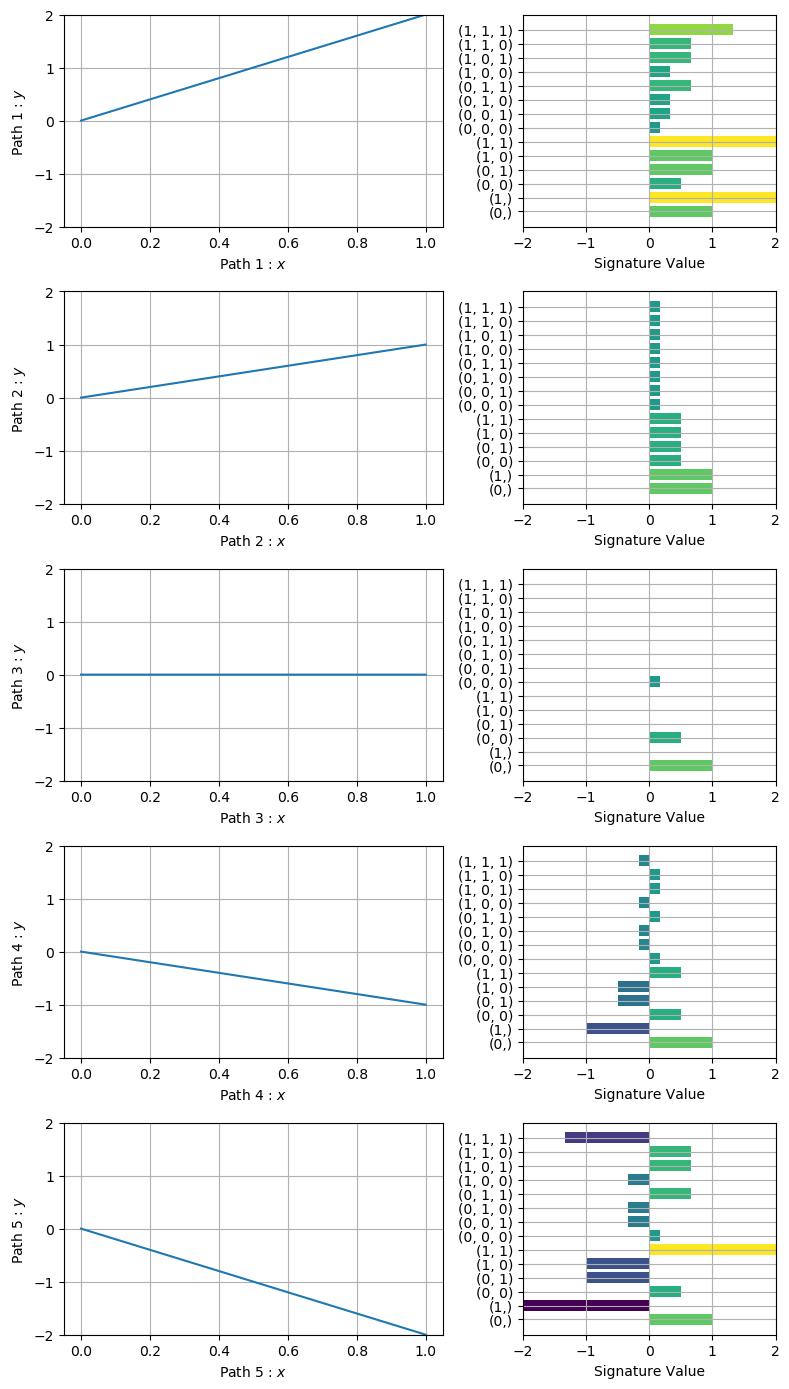

In [5]:
a, b, steps = 0, 1, 10**4+1
t = np.linspace(a, b, steps)

def path_linear_function(t, intercept, slope):
    # return t, t**2 
    return t, intercept + slope*t

path_2d_1 = np.array([path_linear_function(ti, 0,  2) for ti in t])
path_2d_2 = np.array([path_linear_function(ti, 0,  1) for ti in t])
path_2d_3 = np.array([path_linear_function(ti, 0,  0) for ti in t])
path_2d_4 = np.array([path_linear_function(ti, 0, -1) for ti in t])
path_2d_5 = np.array([path_linear_function(ti, 0, -2) for ti in t])

order = 3

s1 = compute_signature( path_2d_1, turncate_order=order )
s2 = compute_signature( path_2d_2, turncate_order=order )
s3 = compute_signature( path_2d_3, turncate_order=order )
s4 = compute_signature( path_2d_4, turncate_order=order )
s5 = compute_signature( path_2d_5, turncate_order=order )

paths = [path_2d_1, path_2d_2, path_2d_3, path_2d_4, path_2d_5]
signatures = [s1,s2,s3,s4,s5]

plot_paths_and_signatures(paths, signatures, order)

Compare the implementation above and the `signatory.signature` package:

In [11]:
torch.tensor( signature_numerical_display(path_2d_1, s1, order) )

tensor([1.0000, 2.0000, 0.5000, 1.0001, 1.0001, 2.0002, 0.1667, 0.3334, 0.3334,
        0.6669, 0.3334, 0.6669, 0.6669, 1.3337], dtype=torch.float64)

In [29]:
signatory.signature( torch.from_numpy(path_2d_1[None,...]), order )

tensor([[1.0000, 2.0000, 0.5000, 1.0000, 1.0000, 2.0000, 0.1667, 0.3333, 0.3333,
         0.6667, 0.3333, 0.6667, 0.6667, 1.3333]], dtype=torch.float64)

The graph on the left column plots the path itself. The righter column shows the values of the signatures, with the indices $(i_1,\cdots,i_k)$ of $S(X)^{i_1, \ldots, i_k}_{a, b}$ on the vertice axes. Notice that the signatures reflects the slope of the path.

Try additional paths and truncate their signatures to order $4$:
1. $X_t = (t,t^2)$
2. $X_t = (t,3t^2)$

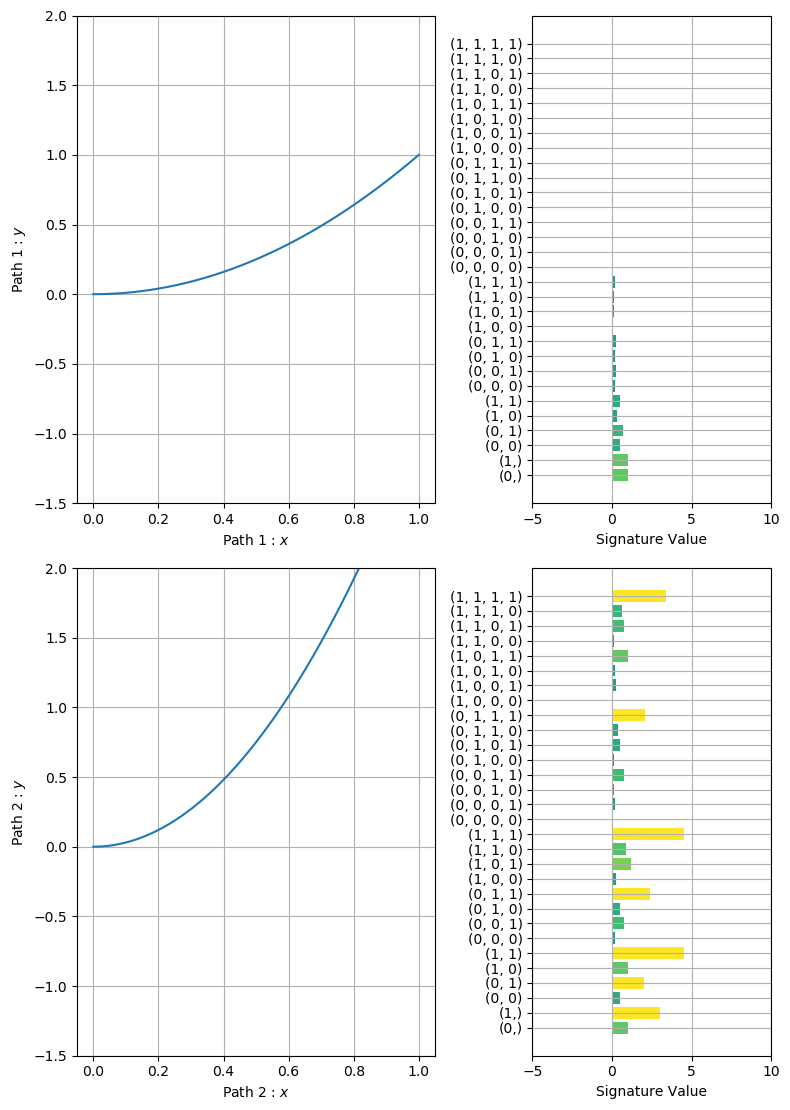

In [13]:
a, b, steps = 0, 1, 10**4+1
t = np.linspace(a, b, steps)

def path_pow_2(t, scalar, shift, const):
    return t, scalar*( t - shift )**2 +  const

def path_pow_3(t, scalar, shift, const):
    return t, scalar*( t - shift )**3 + const

p21 = np.array([path_pow_2(ti, 1,   0,  0) for ti in t])
p22 = np.array([path_pow_2(ti, 3,   0,  0) for ti in t])

order = 4

s21 = compute_signature( p21, turncate_order=order )
s22 = compute_signature( p22, turncate_order=order )


paths = [p21,p22]
signatures = [s21,s22]

plot_paths_and_signatures(paths, signatures, order, path_lim=(-1.5,2), sig_lim=(-5,10))

### Important Properties of Signatures

#### Translation Invariance

The path integrals are invariant with respect to $X_t$ in $\int_a^b Y_u dX_u$. I.e. shifting a path makes no difference in their corresponding signature.

More precisely,  define $Z_t = X_t + c$ with some constant $c \in \mathbb{R}$. We have
$$ \int_a^b Y_t \, dX_t = \int_a^b Y_t \, dZ_t $$

This can be seen the two paths below, which are
1. $X_t = (t, t^2)$
2. $X_t = (t, t^2 - 1)$

for $t \in [-1,1]$.

The two paths below are indeed parallel shifts from the other, and it is clear that their signatures are identical.

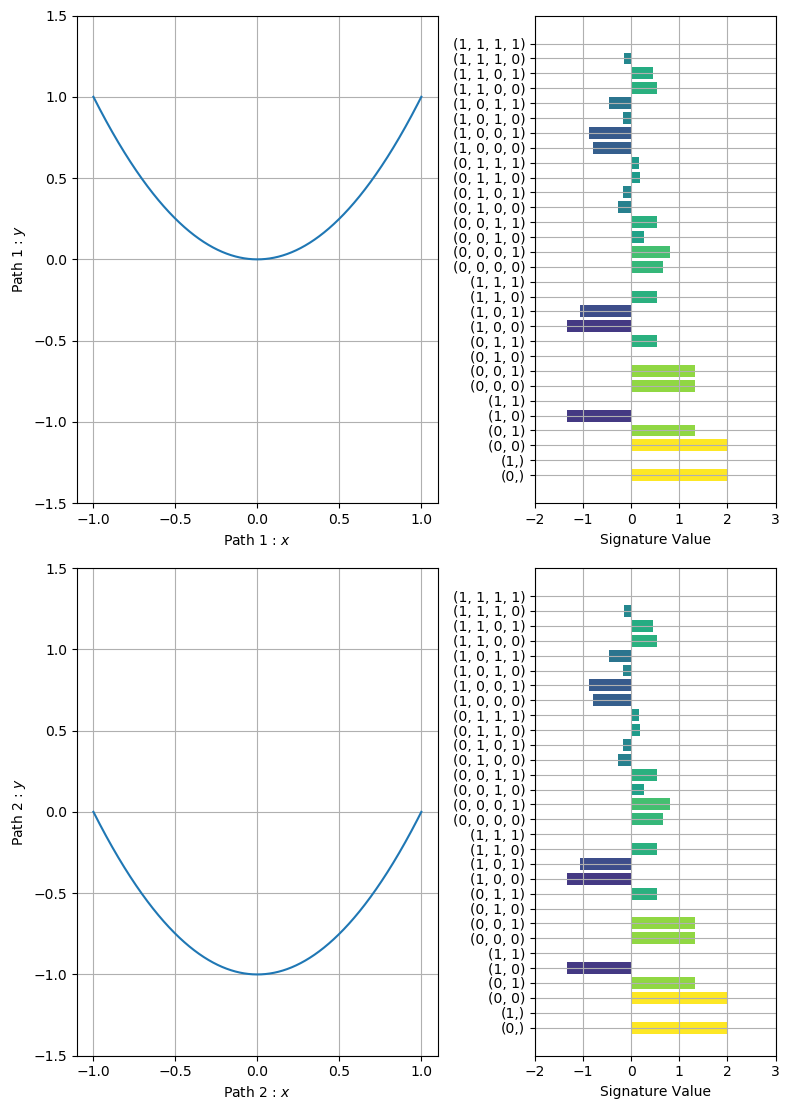

In [14]:
a, b, steps = -1, 1, 2*10**4+1
t = np.linspace(a, b, steps)
order = 4

p23 = np.array([path_pow_2(ti, 1, 0,  0) for ti in t])
p24 = np.array([path_pow_2(ti, 1, 0, -1) for ti in t])

s23 = compute_signature( p23, turncate_order=order )
s24 = compute_signature( p24, turncate_order=order )

paths = [p23,p24]
signatures = [s23,s24]

plot_paths_and_signatures(paths, signatures, order, path_lim=(-1.5,1.5), sig_lim=(-2,3))

#### Reparametrization Invariance

The signatures are infact invariant with respect to $t$ in $\int_a^b Y_t \, dX_t$. In other words, the signature is not affected the speed of the path.

For example, the signature of a hand-written number of a piece of paper is always the same, no matter how fast it is written down.

Below is an example where the shapes of the two paths are the same, while their speeds with respect to time $t$ are different. The paths are:

* $X_t = ( \, \sin(2t) \, , \cos(2t) \, )$ for $t \in [0,\frac{\pi}{2}]$
* $X_t = ( \, \sin(t) \, , \cos(t) \, )$ for $t \in [0,\pi]$


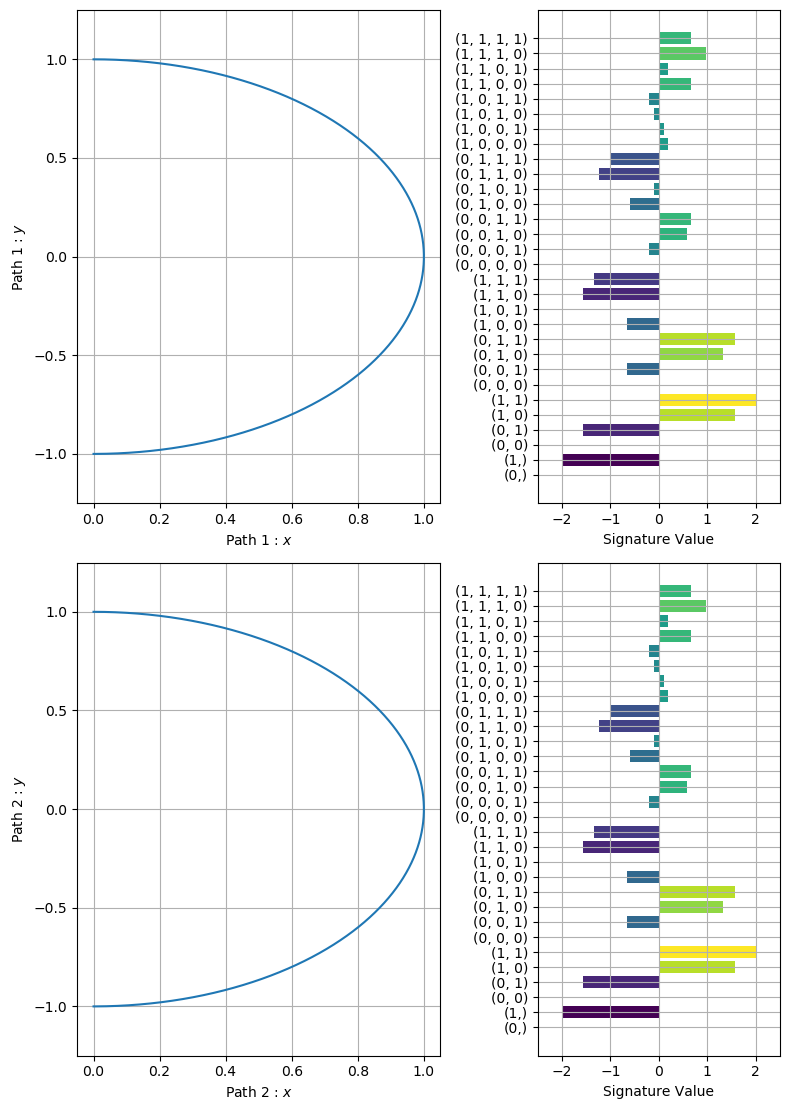

In [27]:
a, b, steps = 0, math.pi/2, 4*10**4+1
t = np.linspace(a, b, steps)

p1 = np.array([(np.sin(2*ti), np.cos(2*ti)) for ti in t])

a, b, steps = 0, math.pi, 4*10**4+1
t = np.linspace(a, b, steps)

p2 = np.array([(np.sin(ti), np.cos(ti)) for ti in t])

order = 4

s1 = compute_signature( p1, turncate_order=order )
s2 = compute_signature( p2, turncate_order=order )

paths = [p1, p2]
signatures = [s1,s2]

plot_paths_and_signatures(paths, signatures, order, path_lim=(-1.25,1.25), sig_lim=(-2.5,2.5))

In [24]:
torch.tensor( signature_numerical_display(p1, s1, order) )

tensor([ 1.5927e-03, -2.0000e+00,  6.2860e-05, -1.5708e+00,  1.5676e+00,
         2.0001e+00,  9.8770e-08, -6.6673e-01,  1.3308e+00,  1.5709e+00,
        -6.6423e-01,  1.9896e-06, -1.5677e+00, -1.3335e+00,  1.9753e-09,
        -1.9640e-01,  5.8804e-01,  6.6676e-01, -5.8698e-01, -9.9631e-02,
        -1.2313e+00, -9.8187e-01,  1.9534e-01,  9.9663e-02, -9.9633e-02,
        -1.9638e-01,  6.6426e-01,  1.9638e-01,  9.7975e-01,  6.6679e-01],
       dtype=torch.float64)

In [23]:
signatory.signature( torch.from_numpy(p1[None,...]), order )

tensor([[ 1.5927e-03, -2.0000e+00,  1.2683e-06, -1.5708e+00,  1.5676e+00,
          2.0000e+00,  6.7331e-10, -6.6667e-01,  1.3308e+00,  1.5708e+00,
         -6.6417e-01,  1.9895e-06, -1.5676e+00, -1.3333e+00,  2.6809e-13,
         -1.9635e-01,  5.8799e-01,  6.6667e-01, -5.8693e-01, -9.9631e-02,
         -1.2312e+00, -9.8175e-01,  1.9529e-01,  9.9632e-02, -9.9633e-02,
         -1.9635e-01,  6.6417e-01,  1.9635e-01,  9.7962e-01,  6.6666e-01]],
       dtype=torch.float64)

To be read: 
* https://github.com/pafoster/path_signatures_introduction/tree/master
* https://www.quantstart.com/articles/rough-path-theory-and-signatures-applied-to-quantitative-finance-part-1/

# Sig-Wasserstein Generative Adversarial Network (Sig-WGAN)

In the section above, we observe that signatures can be a powerful tool describing some time-parameterized paths. The paper [https://arxiv.org/abs/2111.01207](https://arxiv.org/abs/2111.01207) proposed a metric that combines Wasserstein Distance and signature, which is the Signature Wasserstein-1 ($\textrm{Sig-}W_1$) metric.

The motivation is simple, pluging signatured paths into Wasserstein Distance, which is

$$ \underset{ f \textrm{ is 1-Lipshitz} }{ \sup }  \bigg[ \underset{ \mathbf{x} \sim p_{\textrm{real}} }{ \mathbb{E} }  \big[ f( S(\mathbf{x}) ) \big] - \underset{ \mathbf{x} \sim p_g }{ \mathbb{E} }  \big[ f( S(\mathbf{x} ) ) \big] \bigg] \quad \textrm{ where $S(\cdot)$ is the signature. }$$

Moreover, the *universality property* of signature states any continuous functional $f$ on the paths can be arbitrarily well approximated by a linear functional of truncated signatures. This allows us to only consider not only *linear* but also *truncated* functionals, significantly reducing computation.

$$ \textrm{Sig-}W_1^{(M)}( p_{\textrm{real}} , p_g ) = \underset{ L \textrm{ is linear and 1-Lipshitz} }{ \sup } \, L \bigg( \underset{ \mathbf{x} \sim p_{\textrm{real}} }{ \mathbb{E} }  \big[ S^{(M)}(\mathbf{x}) \big] - \underset{ \mathbf{x} \sim p_g }{ \mathbb{E} }  \big[ S^{(M)}(\mathbf{x}) \big] \bigg) $$

# Let's finally begin ...

## train.py, the main function of this project

In [2]:
import itertools
import os
from os import path as pt

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split

from hyperparameters import SIGCWGAN_CONFIGS
from lib import ALGOS
from lib.algos.base import BaseConfig
from lib.data import get_data
from lib.plot import savefig, create_summary
from lib.utils import pickle_it

from train import *

from torch import nn
from typing import Tuple

Below is the core of `train.py`. Comments are made between the code to explain what each section does.

The main parts are:

1. `get_data()`
2. `algo.fit()`
3. Plot & Summarize

In [4]:
def run(algo_id, base_config, base_dir, dataset, spec, data_params={}):
    """ Create the experiment directory, calibrate algorithm, store relevant parameters. """
    print('Executing: %s, %s, %s' % (algo_id, dataset, spec))
    experiment_directory = pt.join(base_dir, dataset, spec, 'seed={}'.format(base_config.seed), algo_id)
    if not pt.exists(experiment_directory):
        # if the experiment directory does not exist we create the directory <<<<
        os.makedirs(experiment_directory)
    
    # >>>> Set seed for exact reproducibility of the experiments <<<<
    set_seed(base_config.seed)
    
    # >>>> initialise dataset and algo <<<<
    x_real = get_data(dataset, base_config.p, base_config.q, **data_params)
    x_real = x_real.to(base_config.device)

    # train test split
    # test set is used to compare with data generated by the generator trained by training set.
    size_train = int(x_real.shape[0] * 0.8)
    indices = np.random.permutation(x_real.shape[0])
    train_idx, test_idx = indices[:size_train], indices[size_train:]
    x_real_train, x_real_test = x_real[train_idx], x_real[test_idx]

    algo = get_algo(algo_id, base_config, dataset, data_params, x_real_train)

    # >>>> Train the algorithm <<<<
    algo.fit()

    # >>> Traing Ends Here <<<

    # >>>> create summary <<<<
    create_summary(dataset, base_config.device, algo.G, base_config.p, base_config.q, x_real_test, experiment_directory)
    savefig('summary.png', experiment_directory)

    # >>>> Save generator weights, real path and hyperparameters. <<<<
    # >>>> Also, graph the paths to see how different they are. <<<<
    pickle_it(x_real, pt.join(pt.dirname(experiment_directory), 'x_real.torch'))
    random_indices = torch.randint(0, x_real.shape[0], (250,))
    for asset_i in range(x_real.shape[2]):
        plt.plot( torch.transpose(x_real[random_indices, base_config.p:, asset_i], 0, 1) , 'C%s' % asset_i, alpha=0.1)
    plt.ylim( (-0.2,0.2) )
    plt.savefig(os.path.join(experiment_directory, 'x_real.png'))
    plt.clf()

    pickle_it(x_real_test, pt.join(pt.dirname(experiment_directory), 'x_real_test.torch'))
    random_indices = torch.randint(0, x_real_test.shape[0], (250,))
    for asset_i in range(x_real_test.shape[2]):
        plt.plot( torch.transpose( x_real_test[random_indices, base_config.p:, asset_i], 0, 1) , 'C%s' % asset_i, alpha=0.1)
    plt.ylim( (-0.2,0.2) )
    plt.savefig(os.path.join(experiment_directory, 'x_real_test.png'))
    plt.clf()
    
    pickle_it(x_real_train, pt.join(pt.dirname(experiment_directory), 'x_real_train.torch'))
    random_indices = torch.randint(0, x_real_train.shape[0], (250,))
    for asset_i in range(x_real_train.shape[2]):
        plt.plot( torch.transpose( x_real_train[random_indices, base_config.p:, asset_i], 0, 1) , 'C%s' % asset_i, alpha=0.1)
    plt.ylim( (-0.2,0.2) )
    plt.savefig(os.path.join(experiment_directory, 'x_real_train.png'))
    plt.clf()

    pickle_it(algo.training_loss, pt.join(experiment_directory, 'training_loss.pkl'))
    pickle_it(algo.G.to('cpu').state_dict(), pt.join(experiment_directory, 'G_weights.torch'))
    
    # >>>> Log some results <<<<
    algo.plot_losses()
    savefig('losses', experiment_directory)


def main(args):
    if not pt.exists('./data'):
        os.mkdir('./data')

    print('Start of training. CUDA: %s' % args.use_cuda)
    for dataset in args.datasets:
        for algo_id in args.algos:
            for seed in range(args.initial_seed, args.initial_seed + args.num_seeds):
                
                print(f"dataset={dataset} / algo={algo_id} / seed={seed}")
                
                base_config = BaseConfig(
                        device='cuda:{}'.format(args.device) if args.use_cuda and torch.cuda.is_available() else 'cpu',
                    seed=seed,
                    batch_size=args.batch_size,
                    hidden_dims=args.hidden_dims,
                    p=args.p,
                    q=args.q,
                    total_steps=args.total_steps,
                    mc_samples=1000,
                )
                set_seed(seed)
                generator = get_dataset_configuration(dataset)
                for spec, data_params in generator:
                    run(
                        algo_id=algo_id,
                        base_config=base_config,
                        data_params=data_params,
                        dataset=dataset,
                        base_dir=args.base_dir,
                        spec=spec,
                    )

**To start training, run the block below**

In [ ]:
import argparse
class Args(argparse.Namespace):
    base_dir     = './numerical_results'
    use_cuda     = 'store_true'
    device       = 0
    num_seeds    = 1
    initial_seed = 0
    datasets     = ['BINANCE', ]
    algos        = ['CWGAN','SigCWGAN',]
    batch_size   = 200
    p            = 24
    q            = 6
    hidden_dims  = 3 * (50,)
    total_steps  = 100

args = Args()
main(args)


# Notations

* $N$ is the total number of closing prices for each asset.
* $d$ is the number of total assets.
* $p$ is the length of past data that we are conditioning on.
* $q$ is the length of generated data.

# [1] `get_data()`

First, call `get_binance_dataset()` which reads the csv of each Binance asset and concatenates all of their closing prices into a 3D-tensor whose size is $(1,N,d)$. Here, $N$ is the total number of closing prices for each asset and $d$ is the number of total assets.

Then, the $(1,N,d)$ tensor is thrown into `zero_based_rolling_window()`. The output is a $( \, N-(p+q) \, , \, p+q \, , \, d \, )$ 3D-tensor, where $p$ is the length of past data that we are conditioning on and $q$ is the length of generated data. This is done by following this procedure:

1. Call each entry of the second dimension of the $(1,N,d)$ tensor $x_t$, so $t=0,1,\ldots,N-1$.
2. For $t=0$ to $N-(p+q)$ (the start of each windonw)
    1. First take the next $p+q$ $x_t$'s, which are $x_t,\ldots,x_{t+(p+q-1)}$.
    2. Compute $y_{s} := \dfrac{ (x_s-x_t) }{ x_t }$ for $s=t,t+1,\ldots,t+(p+q-1)$, which is the relative change of price to the price at the start of the window.
    3. Collect $y_t,y_{t+1},\ldots,y_{t+(p+q-1)}$ to form a $(1,p+q,d)$ tensor.
3. Collect all $(1,p+q,d)$ tensors to form a $(N-(p+q),p+q,d)$ tensor. Return this tensor.

# [2] `algo.fit()`

The `fit()` function is defined by the `BaseAlgo` class. When the `fit()` function is called, we enter a training loop whose number of iterations is determined by `base_config.total_steps`. This value decides how many times the generator is trained before stopping.

An iteration is called a `step()`, which is defined by `gans.py`, `gmmn.py`, `sigcwgan.py` depending on the algorithm. I will explain how `step()` works under different algorithms.

## `GANs.py`

The class `GAN` whose base class is `BaseAlgo` is equipped with:
* a `ResFNN` discriminator ( `D` ) from `./lib/arfnn.py`
* a `SimpleGenerator` generator ( `G` ) from `./lib/algos/base.py`.

The pseudocode for `step()` is as follows:

1. Loop `self.D_steps_per_G_step` times (Train the discriminator this many times.)
    1. Randomly sample some real paths of length $p+q$. The number of real paths is decided by `self.batch_size`.
    2. Regard the generator as given, for eaxh real path, use the first $p$ entries to generate the next $q$ entries (fake path of length $q$, conditional on historic data of length $p$). This is done by calling `G.sample().`
    3. Concatenate the real part and fake part to form length-$(p+q)$ paths.
    4. Train the discriminator by comparing how different [the entirely-real paths] and [the paths with fake parts] are. This is done by calling `D_trainstep()`.
    5. Record the loss from the discriminator.
2. Randomly sample some length-$p$ real paths and generate length-$q$ future paths.
3. Concatenate them into a length-$(p+q)$ paths.
4. Regard the discriminator as given, train the generator by using the discriminator to compare how different [the entirely-real paths] and [the paths with fake parts] are. This is done by calling `G_trainstep()`.
5. Record the loss from the generator.

Notice that I mention "comparison between real and fake data" in the pseudocode. The pseudocode is as follows:
1. Provide the discriminator with entirely-real data.
2. Measure the loss between the real data and $1$.
3. Provide the discriminator with data with fake parts.
4. Measure the loss between the fake data and $0$.

The `ResFNN` discriminator has inputs:
* `input_dim` $= (p+q) \times d$,
* `hidden_dims` $= (50,50,50)$,
* `output_dim` $= 1$ which is a $[0,1]$ output. If the value is close to $1$, the discriminator thinks the input is real. If it's close to $0$, its considered fake/generated.

There are four GANs to try with:
1. Recurrent Conditional GAN (`RCGAN`)
2. Time-Series GAN (`TimeGAN`)

The loss function of 1. & 2. is `torch.nn.functional.binary_cross_entropy_with_logits()`

3. Recurrent Conditional Weierstrass GAN (`RCWGAN`)
4. ConditionalWGAN (`CWGAN`)

The loss function of 3. & 4. is
$$ (2 \times \text{target} - 1) \times \text{discriminator}_{\text{out}}$$

The `SimpleGenerator` has a `ArFNN` (autoregressive feedforward neural network) architecture:

$$ (x,z) \in \mathbb{R}^{p \times d} \times \mathbb{R}^{1 \times d} = \mathbb{R}^{(p+1) \times d} \overset{A_1}\longrightarrow \mathbb{R}^{50} \overset{\phi_\alpha}\longrightarrow \mathbb{R}^{50} \overset{R_2}\longrightarrow \mathbb{R}^{50} \overset{R_3}\longrightarrow \mathbb{R}^{50} \overset{A_4}\longrightarrow \mathbb{R}^{d} $$

In `gans.py`, the generator `G` calls the `sample()` function, which iteratively generates the future path according to Algorithm 1 on Page 15. 

In short, Algorithm 1 uses past data of length $p$ to generate one new value, then uses the past $p-1$ data plus the newly-generated data (so there are still $p$ data in total) to generate one extra new data. This procedure is done iteratively until we have generated and collected a path of length $q$. 

See the comments in code to understand how input data is transformed.

In [ ]:
class ResFNN(nn.Module):
    pass  # omitted

class ArFNN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: Tuple[int]):
        super().__init__()
        self.network = ResFNN(input_dim, output_dim, hidden_dims)

    def forward(self, z, x_past):
        x_generated = list()
        for t in range(z.shape[1]):
            # d=2, p=24
            z_t = z[:, t:t+1]
            # z_t: torch.Size([200000, 1, d=2])  x:torch.Size([200000, 1, p*d=48])
            x_in = torch.cat([z_t, x_past.reshape(x_past.shape[0], 1, -1)], dim=-1)
            # x_in: torch.Size([200000, 1, d*(p+1)=50])
            # (x,z) is created as x_in
            
            # >>> ResFNN Generator <<<
            x_gen = self.network(x_in)  # Calls ResFNN().network(), layer A_4 outputs here. See below for more.
            # x_gen:torch.Size([200000, 1, d=2])
            
            x_past = torch.cat([x_past[:, 1:], x_gen], dim=1) # iterative replace and append
            # x_past:torch.Size([200000, 1, p=24])
            x_generated.append(x_gen)
        x_fake = torch.cat(x_generated, dim=1)
        return x_fake

class SimpleGenerator(ArFNN):
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: Tuple[int], latent_dim: int):
        super(SimpleGenerator, self).__init__(input_dim + latent_dim, output_dim, hidden_dims)
        self.latent_dim = latent_dim

    def sample(self, steps, x_past):
        '''
        [Usage] generator.sample( q, x_past ) where x_past has length p.
        '''
        # self.latent_dim = d
        z = torch.randn(x_past.size(0), steps, self.latent_dim).to(x_past.device)
        return self.forward(z, x_past)

Note that up until `network()` is called, we have a $(x,z) \in \mathbb{R}^{(p+1) \times d}$ tensor.

When `network()` is called, the network of `ResFNN` is instantiated, which takes the $\mathbb{R}^{(p+1) \times d}$ tensor as input. We set `hiddem_dims` to be $(50,50,50)$, so, as a result of the for loop below, there will be three `ResidualBlocks` ($\phi_\alpha \circ A_1: \mathbb{R}^{(p+1) \times d} \rightarrow \mathbb{R}^{50}$, $R_2: \mathbb{R}^{50} \rightarrow \mathbb{R}^{50}$, and $R_3: \mathbb{R}^{50} \rightarrow \mathbb{R}^{50}$). Finally, one more `Linear` layer ($A_4$) is appended, which maps  $\mathbb{R}^{50}$ to $\mathbb{R}^d$.

In [2]:
p = 24
d = 2

class ResidualBlock():
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(ResidualBlock, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.PReLU()
        self.create_residual_connection = True if input_dim == output_dim else False

class ResFNN(nn.Module):
    def __init__(self, input_dim=(p+1)*d, output_dim=d, hidden_dims=(50,50,50), flatten: bool = False):
        blocks = list()
        input_dim_block = input_dim  # initially R^{ (p+1) * d }
        for hidden_dim in hidden_dims:
            blocks.append(ResidualBlock(input_dim_block, hidden_dim))  # layers A_1, R_2, and R_3
            input_dim_block = hidden_dim  # becomes R^{ 50 }
        blocks.append(nn.Linear(input_dim_block, output_dim))  # layer A_4

# [3] Summarizing & Plotting the results

1. Call `create_summary()` from `./lib/plot.py`
    1. Take the length-$(p+q)$ real paths from the **test set**. (Call the last $q$ entries `x_real_future`)
    2. Use their first $p$ entries to generate the next $q$ fake entries. (Call the $q$ entries `x_fake_future`)
    3. Call `plot_summary()` to compare `x_real_future` and `x_fake_future` by visualizing their distributions (histogram) and autocorrelation graph.
2. Plot and pickle and the paths
3. Plot the loss progressions. See `get_standard_test_metrics()` in `./lib/algos/base.py` for all the losses.

# My Result

* Input BTC & ETH 1 hour Binance close.
* $p=24$, $q=6$
* Algorithm: Conditional Weierstrass GAN (CWGAN)

The full results can be found in `./numerical_results`

![alt text](./numerical_results/BINANCE/BTC_ETH/seed=0/CWGAN/summary.png "Title")

$x_{ \text{real future, test} }$

![alt text](./numerical_results/BINANCE/BTC_ETH/seed=0/CWGAN/x_real_test.png "Title")

$x_{ \text{fake future} }$

![alt text](./numerical_results/BINANCE/BTC_ETH/seed=0/CWGAN/x_fake_future.png "Title")